In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Paths to our data
train_data_path = '/kaggle/input/retina-blood-vessel/Data/train/image'
train_label_path = '/kaggle/input/retina-blood-vessel/Data/train/mask'

# Load images from a folder
def load_images_from_folder(folder_path):
    images = []
    # Ensure folder exists
    if not os.path.exists(folder_path):
        print(f"Error: The folder {folder_path} does not exist.")
        return images

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Only load image files
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(file_path, cv2.IMREAD_COLOR)
            if img is not None:
                images.append(img)
            else:
                print(f"Warning: Unable to read image {file_path}")
        else:
            print(f"Skipping non-image file: {filename}")
    return images

# Load datasets
train_data = load_images_from_folder(train_data_path)
train_labels = load_images_from_folder(train_label_path)

# Print dataset sizes
print("Training data size:", len(train_data))
print("Training label size:", len(train_labels))


Training data size: 80
Training label size: 80


In [3]:
# Function to display a random sample of images
def display_random_images(folder_path, num_samples=3):
    # Load images
    images = load_images_from_folder(folder_path)

    # Check if we have enough images
    if len(images) < num_samples:
        print(f"Error: Only {len(images)} images available, but {num_samples} requested.")
        return

    # Randomly select images
    random_indices = random.sample(range(len(images)), num_samples)
    selected_images = [images[i] for i in random_indices]

    # Plot the sample images
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Hide axes
        plt.title(f"Sample {i+1}")

    plt.tight_layout()
    plt.show()

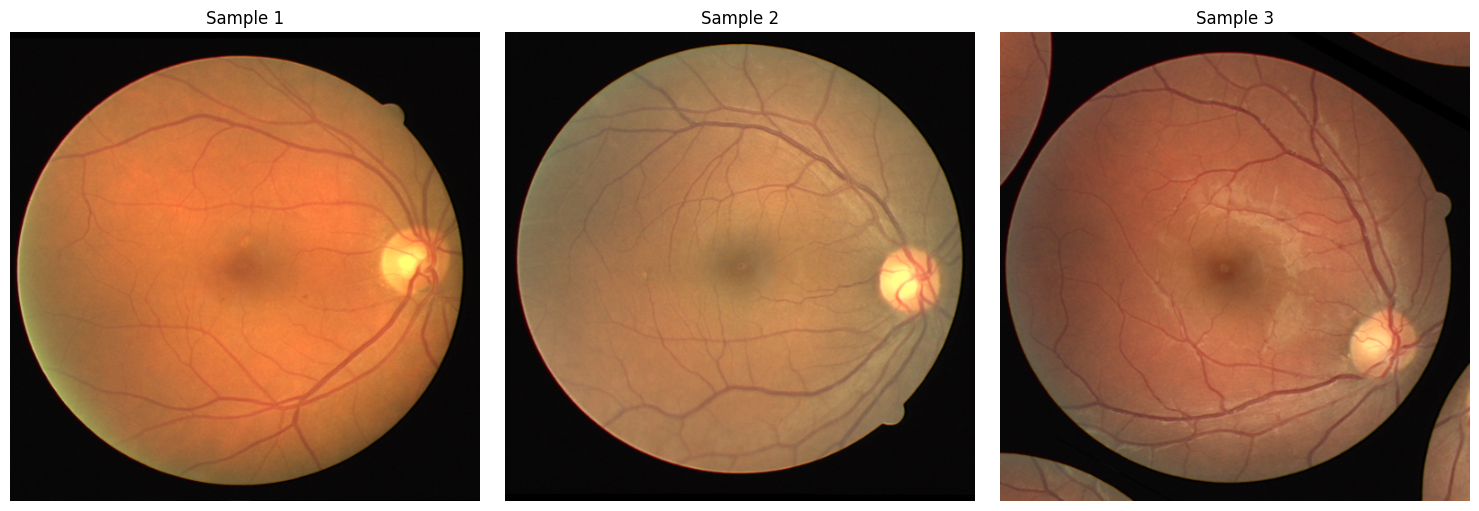

In [4]:
display_random_images(train_data_path)

### Preprocessing Techniques  

1. **Noise-Free Dataset**: Our dataset is clean and does not contain noise.  
2. **Grayscale Conversion**: Images are converted to grayscale for preprocessing.  
3. **Histogram Equalization**: Used to adjust illumination across images for better visibility.  
4. **Edge Detection**: Applied the Canny Edge Detector for identifying edges effectively. 

In [5]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Resize all images to a fixed size
IMG_HEIGHT, IMG_WIDTH = 128, 128

def preprocess_data_with_display(image_folder, label_folder):
    images, labels, edges = [], [], []

    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        label_path = os.path.join(label_folder, filename)

        if os.path.exists(label_path):
            # Load images and labels
            img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            label = load_img(label_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")

            # Convert to arrays and normalize
            img_array = img_to_array(img) / 255.0
            label_array = img_to_array(label) / 255.0  # Normalize the label image to [0, 1]

            # Convert the image to grayscale for further processing
            gray_img = cv2.cvtColor((img_array * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

            # Histogram Equalization
            equalized_img = cv2.equalizeHist(gray_img)

            # Normalize the equalized image
            equalized_img = equalized_img / 255.0

            # Edge Detection (Canny Edge Detector)
            edges_img = cv2.Canny((equalized_img * 255).astype(np.uint8), threshold1=100, threshold2=200)
            edges_img = edges_img / 255.0  # Normalize edges to [0, 1]

            # Append processed images, labels, and edges
            images.append(equalized_img)  # Use the equalized grayscale image
            labels.append(label_array)  # Use the normalized segmentation label
            edges.append(edges_img)  # Add the edge-detected image as an additional feature

    # Convert lists to arrays
    images, labels, edges = np.array(images), np.array(labels), np.array(edges)

    # Display a random image in all its stages
    if len(images) > 0:
        random_index = random.randint(0, len(images) - 1)
        display_image_stages(images[random_index], edges[random_index], labels[random_index])

    return images, labels, edges

In [6]:
# Helper function for image subplots
def display_image_stages(original, edge_detected, label):
    plt.figure(figsize=(15, 5))

    # Display original image (histogram equalized grayscale)
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original (Equalized)")
    plt.axis('off')

    # Display edge-detected image
    plt.subplot(1, 3, 2)
    plt.imshow(edge_detected, cmap='gray')
    plt.title("Edge Detected")
    plt.axis('off')

    # Display label image
    plt.subplot(1, 3, 3)
    plt.imshow(label.squeeze(), cmap='gray')  # Use squeeze to handle grayscale dimensions
    plt.title("Label")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


##  Display a sample equalized image, the same image after edge detection and comparing to its label

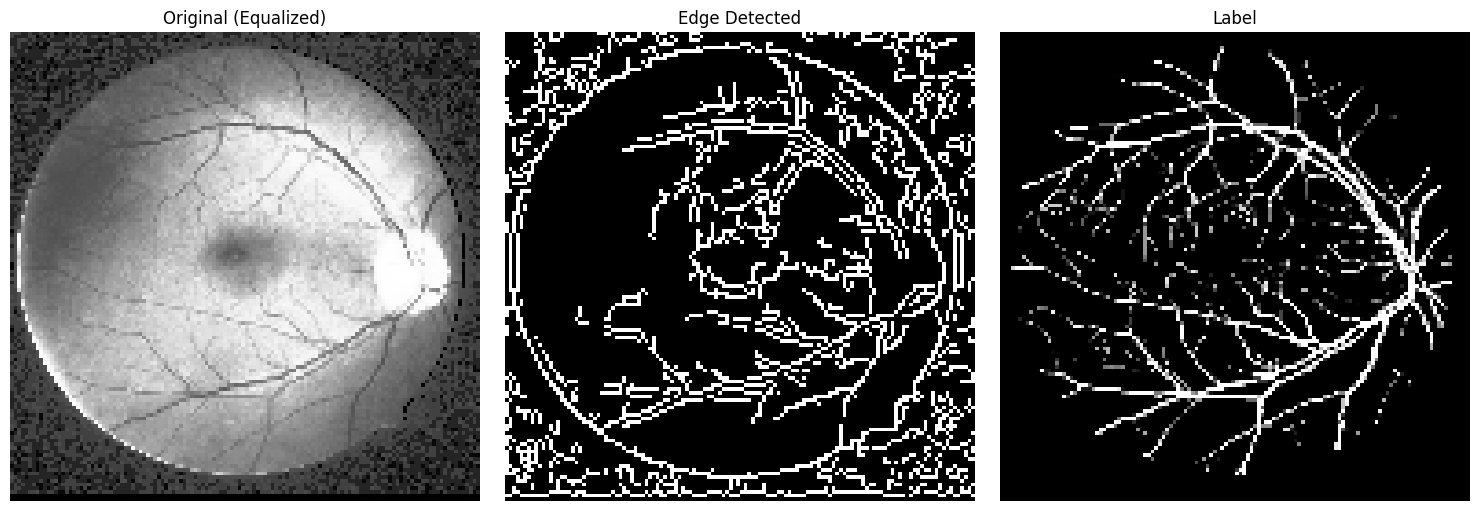

In [7]:
preprocessed_images, preprocessed_labels, preprocessed_edges = preprocess_data_with_display(train_data_path, train_label_path)

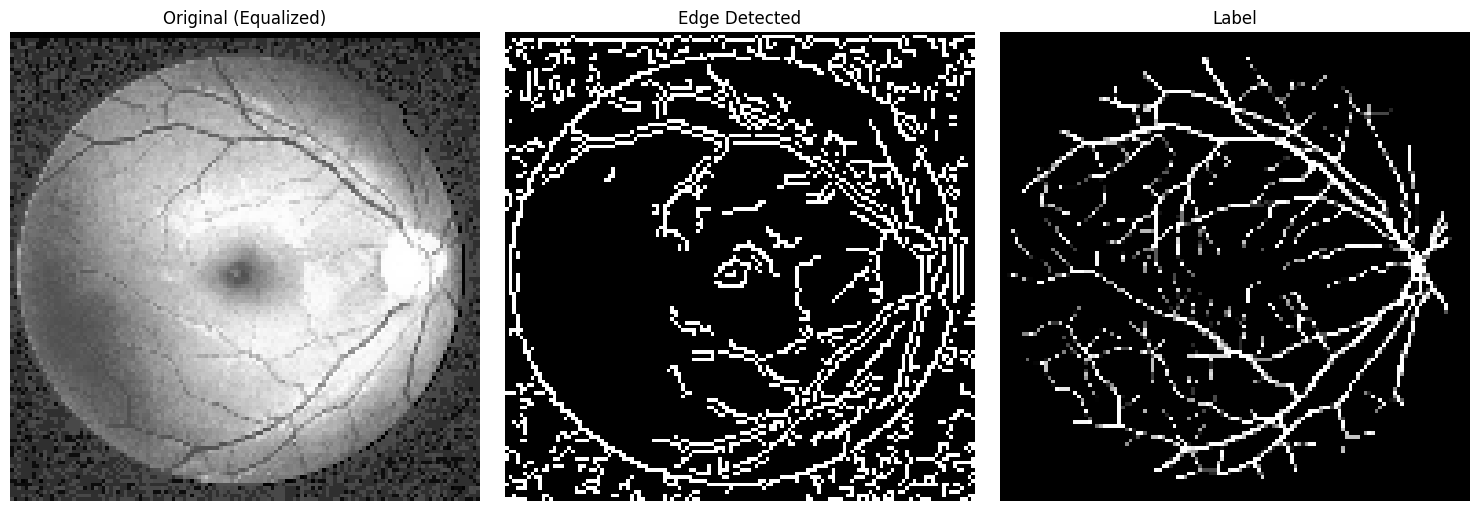

Training data shape: (80, 128, 128, 2), (80, 128, 128, 1)


In [8]:
# Load and preprocess datasets
train_images, train_labels, train_edges = preprocess_data_with_display(train_data_path, train_label_path)
# Expand dimensions of edges to match input shape
train_edges = np.expand_dims(train_edges, axis=-1)


# Stack grayscale images and edges as multi-channel inputs
train_images_combined = np.stack((train_images, train_edges.squeeze()), axis=-1) # (num_samples, height, width, 1), the .squeeze() method removes the last dimension (size 1)


# Print shapes of Our Data
print(f"Training data shape: {train_images_combined.shape}, {train_labels.shape}")



## Data Augmentation

In [9]:
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, #  for Distortion
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# The U-Net Architecture For Segmentation Step :-

### U-Net Architecture  

U-Net is a **U-shaped convolutional neural network** for image segmentation. It has:  

1. **Encoder:** Extracts features using convolutions and max-pooling.  
2. **Decoder:** Restores spatial resolution using up-sampling.  
3. **Skip Connections:** Link encoder and decoder layers to preserve spatial details. 

In [10]:
from tensorflow.keras import layers, models

def attention_block(x, g, inter_channels):
    """
    Attention block for the U-Net model.

    Args:
        x: Tensor from the encoder (skip connection).
        g: Tensor from the decoder (up-sampled feature map).
        inter_channels: Number of intermediate channels for the attention mechanism.

    Returns:
        Tensor after applying attention mechanism.
    """
    theta_x = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(g)
    
    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='sigmoid')(relu)

    attention = layers.Multiply()([x, psi])
    return attention

def build_unet_with_attention(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder with Attention
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    a6 = attention_block(c4, u6, 256)
    u6 = layers.concatenate([u6, a6])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    a7 = attention_block(c3, u7, 128)
    u7 = layers.concatenate([u7, a7])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    a8 = attention_block(c2, u8, 64)
    u8 = layers.concatenate([u8, a8])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    a9 = attention_block(c1, u9, 32)
    u9 = layers.concatenate([u9, a9])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the U-Net model with attention
input_shape = (128, 128, 1)
model = build_unet_with_attention(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 16, 16, 256)    │        131,328 │ conv2d_7[0][0]         │
├──────────────────────

 Total params: 31,380,197 (119.71 MB)

 Trainable params: 31,380,197 (119.71 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [11]:
history = model.fit(
    train_images, train_labels,
    batch_size=4,
    epochs=30
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7321 - loss: 2.1711
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8782 - loss: 0.5048
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8766 - loss: 0.3406
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.8778 - loss: 0.2970
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.8754 - loss: 0.2716
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.8775 - loss: 0.2621
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8755 - loss: 0.2626
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.8784 - loss: 0.2560
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8756 - loss: 0.2514
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8792 - loss: 0.2342
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8792 - loss: 0.2319
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8889 - lo

## Saving the Model

In [12]:
model.save('unet_model.h5')

## Loading Test Data 

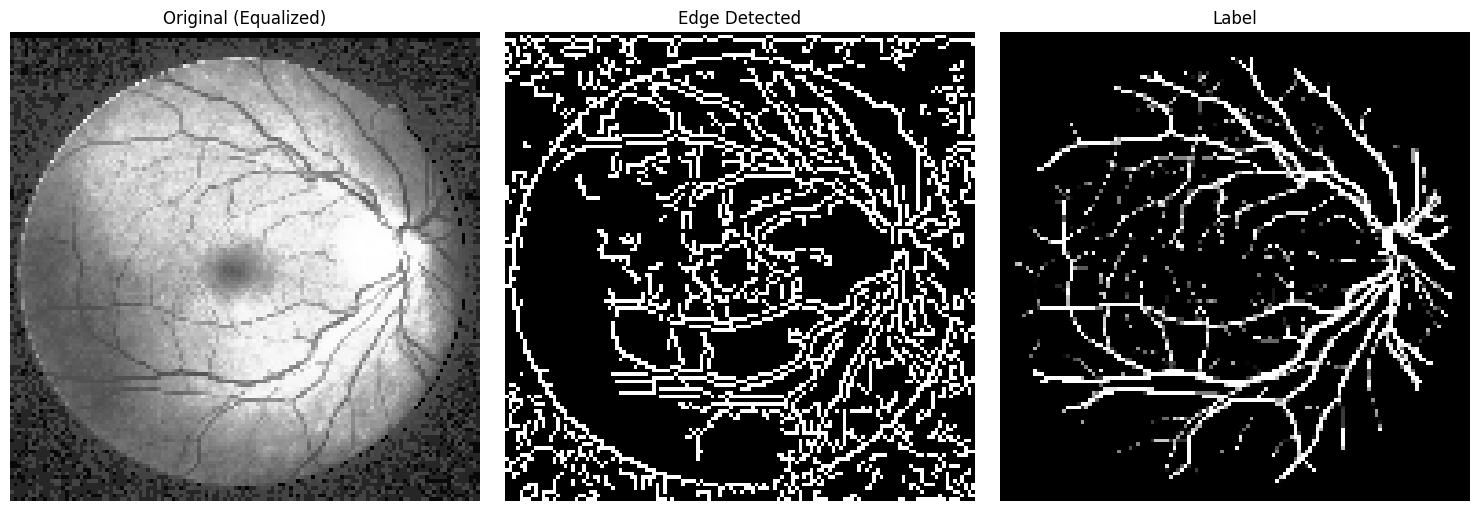

In [13]:
test_data_path="/kaggle/input/retina-blood-vessel/Data/test/image"
test_label_path="/kaggle/input/retina-blood-vessel/Data/test/mask"

test_data = load_images_from_folder(test_data_path)
test_labels = load_images_from_folder(test_label_path)

test_images, test_labels, test_edges = preprocess_data_with_display(test_data_path, test_label_path)
test_edges = np.expand_dims(test_edges, axis=-1)
test_images_combined = np.stack((test_images, test_edges.squeeze()), axis=-1)

## Evaluate Testing Data

In [14]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9086 - loss: 0.1508
Test Loss: 0.15083642303943634, Test Accuracy: 0.9086334109306335


## Plotting Original , true and predicted image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


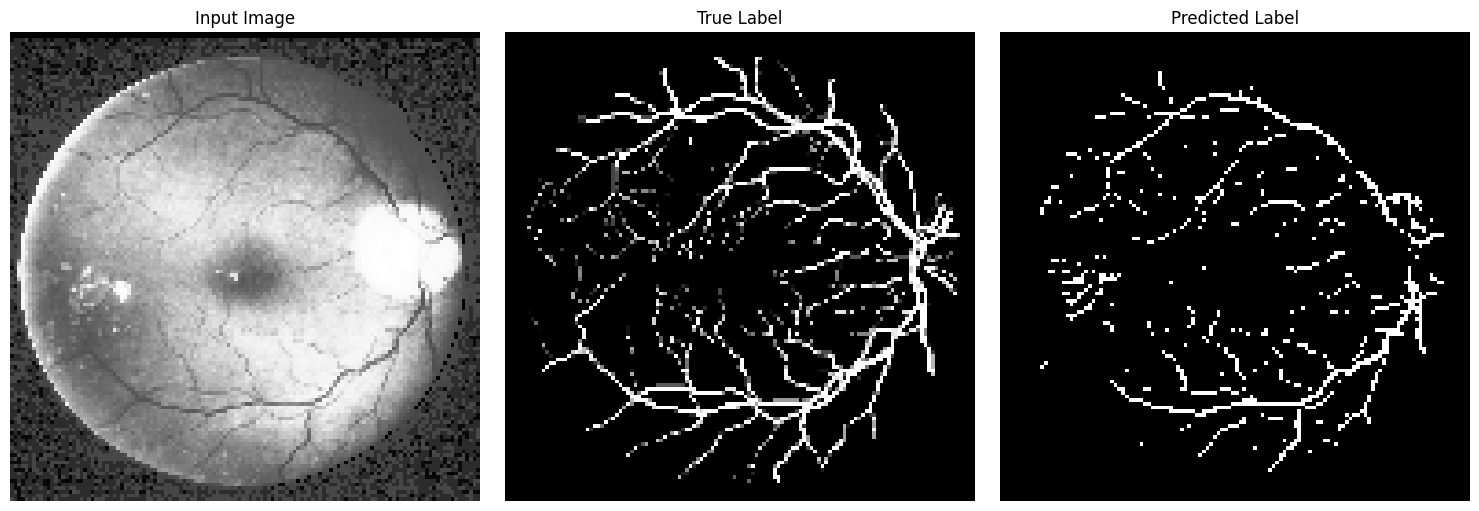

In [15]:
def visualize_single_prediction(model, images, labels):
    index = random.randint(0, len(images) - 1)

    # Get the prediction for the specified image
    prediction = model.predict(images[index:index+1])

    # Normalize the prediction to binary values (0 or 1) for visualization
    prediction = (prediction > 0.5).astype(np.uint8)

    # Set up the plot
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    # Plot true label
    plt.subplot(1, 3, 2)
    plt.imshow(labels[index], cmap='gray')
    plt.title('True Label')
    plt.axis('off')

    # Plot predicted label
    plt.subplot(1, 3, 3)
    plt.imshow(prediction[0], cmap='gray')
    plt.title('Predicted Label')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_single_prediction(model, test_images, test_labels)